# Intro

# Libraries

In [1]:
import gc
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as st
import seaborn as sns
from stable_baselines3.a2c import A2C
from stable_baselines3.ppo import PPO

import src.algorithms.algo_utils as autil
import src.envs.resource_allocation_env as rae
from src.algorithms.dummy import DummyAgent
from src.envs.resource_allocation_env import NumericalAllocProjectsEnv, OptimizerAgent


C:\Users\filip\anaconda3\envs\py39\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#  Env setup

In [2]:
ENV_SIZE = 300

In [12]:
np.random.seed(666)
env = NumericalAllocProjectsEnv(
        start_resource=100,
        start_cash=100,
        upkeep_cost=-1,
        min_payout=-0.5,
        max_payout=1.5,
        increase_resource_cost=-1.5,
        payout_mean=1.,
        payout_std=1.5,
        size=ENV_SIZE,
        pnl_is_reward=True,
        stochastic=True,
        normalize_from=None)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]

C:\Users\filip\anaconda3\envs\py39\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [13]:
print('done')

done


# Agents

In [14]:
class BaselinesWrapper:

    def __init__(self, baselines_agent):
        self.agent = baselines_agent

    def choose_action(self, s: np.array, *args, **kwargs) -> Tuple[np.array, np.array]:
        return self.agent.predict(s)

In [15]:
gc.collect()
dummy_agent = DummyAgent(env)
optimizer_agent = OptimizerAgent(env)
ppo_policy_kwargs = dict(net_arch=[128,
                                   dict(pi=[128, 128], vf=[64, 64])])
ppo_agent = PPO('MlpPolicy', env, policy_kwargs=ppo_policy_kwargs, verbose=1, ent_coef=0.001)
a2c_agent = A2C('MlpPolicy', env, policy_kwargs=ppo_policy_kwargs, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [16]:
ppo_agent.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Tanh()
    )
    (policy_net): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=128, out_features=4, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

# Evaluate before training

In [54]:
optimizer_scores = autil.evaluate_algorithm(optimizer_agent, env, n_episodes=100, max_ep_steps=ENV_SIZE, clip_action=False, last_reward_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
dummy_scores = autil.evaluate_algorithm(dummy_agent, env, n_episodes=100, max_ep_steps=ENV_SIZE, clip_action=False, last_reward_only=True)
ppo_scores_before = autil.evaluate_algorithm(BaselinesWrapper(ppo_agent), env, n_episodes=100, max_ep_steps=ENV_SIZE, clip_action=False, last_reward_only=True)
a2c_scores_before = autil.evaluate_algorithm(BaselinesWrapper(a2c_agent), env, n_episodes=100, max_ep_steps=ENV_SIZE, clip_action=False, last_reward_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

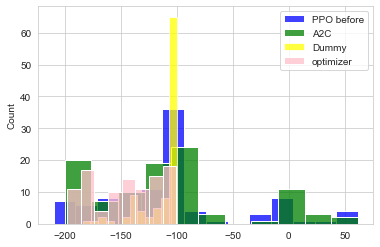

In [55]:
sns.histplot(ppo_scores_before, color='blue', label='PPO before')
sns.histplot(a2c_scores_before, color='green', label='A2C')
sns.histplot(dummy_scores, color='yellow', label='Dummy')
sns.histplot(optimizer_scores, color='pink', label='optimizer')
plt.legend()

In [33]:
actions = []
episodes = 1000
for ep in range(episodes):
    s = env.reset()
    done = False
    while not done:
        a, _ = a2c_agent.predict(s)
        sprime, reward, done, _ = env.step(a)
        actions.append(a)
        s = sprime

# Train agent

In [36]:
ppo_agent.learn(total_timesteps=200000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.92     |
|    ep_rew_mean     | -155     |
| time/              |          |
|    fps             | 960      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.65        |
|    ep_rew_mean          | -147        |
| time/                   |             |
|    fps                  | 728         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.024398644 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.69       |
|    explained_variance   | 0.00178     |
|    learning_rate        | 0.

In [37]:
a2c_agent.learn(total_timesteps=200000)

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.66      |
|    ep_rew_mean        | 258       |
| time/                 |           |
|    fps                | 606       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -5.66     |
|    explained_variance | -6.68e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 6.23e+03  |
|    std                | 0.996     |
|    value_loss         | 1.6e+06   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 8.89     |
|    ep_rew_mean        | 3.1e+03  |
| time/                 |          |
|    fps                | 601      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps

# Eval after train

In [56]:
ppo_scores_after = autil.evaluate_algorithm(BaselinesWrapper(ppo_agent), env, n_episodes=100, max_ep_steps=ENV_SIZE,
                                                clip_action=False, last_reward_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
a2c_scores_after = autil.evaluate_algorithm(BaselinesWrapper(a2c_agent), env, n_episodes=100, max_ep_steps=ENV_SIZE,
                                                clip_action=False, last_reward_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]

# Compare results

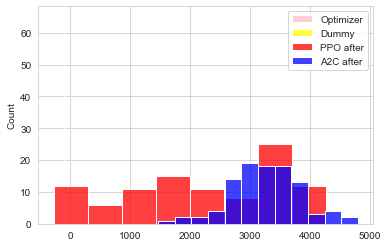

In [58]:
sns.histplot(optimizer_scores, color='pink', label='Optimizer')
sns.histplot(dummy_scores, color='yellow', label='Dummy')
sns.histplot(ppo_scores_after, color='red', label='PPO after')
sns.histplot(a2c_scores_after, color='blue', label='A2C after')
plt.legend()

In [59]:
result_df = pd.DataFrame({
    'A2C_after': a2c_scores_after,
    'A2C before': a2c_scores_before,
    'PPO after': ppo_scores_after,
    'PPO before': ppo_scores_before,
    'optimizer': optimizer_scores,
    'baseline': dummy_scores, })
result_df.describe()

,A2C_after,A2C before,PPO after,PPO before,optimizer,baseline
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3254.915325,-108.733098,2226.119154,-104.507110,-144.281742,-112.238088
std,595.253783,65.291586,1303.793837,62.881019,30.313331,19.026399
min,1461.995385,-200.000000,-279.808431,-209.733609,-197.952200,-184.000000
25%,2922.717592,-156.789839,1380.313467,-146.244610,-174.742855,-117.676399
50%,3283.483023,-107.153676,2276.954727,-103.681186,-139.098274,-102.437520
75%,3592.070306,-100.000000,3326.107297,-100.000000,-116.799556,-100.055741
max,4800.772475,61.731637,4273.706995,61.731637,-100.382907,-100.000000


In [60]:
stat, pval = st.levene(*[result_df[c] for c in result_df.columns])
pval.round(4)

0.0

In [61]:
melted_df = result_df.melt(var_name='model')
result = pg.welch_anova(melted_df, dv='value', between='model')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,model,5,258.159195,717.514276,3.818318e-149,0.848255


In [62]:
pg.pairwise_gameshowell(melted_df, dv='value', between='model', effsize='cohen')

,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,A2C before,A2C_after,-108.733098,3254.915325,-3363.648423,59.882390,-56.170912,101.381839,0.000000e+00,-7.943767
1,A2C before,PPO after,-108.733098,2226.119154,-2334.852252,130.542765,-17.885727,99.496545,0.000000e+00,-2.529424
2,A2C before,PPO before,-108.733098,-104.507110,-4.225989,9.064775,-0.466199,197.720455,9.972208e-01,-0.065930
3,A2C before,baseline,-108.733098,-112.238088,3.504990,6.800732,0.515384,115.693349,9.954851e-01,0.072886
4,A2C before,optimizer,-108.733098,-144.281742,35.548644,7.198534,4.938317,139.784417,3.231932e-05,0.698383
5,A2C_after,PPO after,3254.915325,2226.119154,1028.796172,143.324996,7.178065,138.553118,5.868359e-10,1.015132
6,A2C_after,PPO before,3254.915325,-104.507110,3359.422435,59.856586,56.124525,101.209255,8.437695e-15,7.937206
7,A2C_after,baseline,3254.915325,-112.238088,3367.153414,59.555778,56.537813,99.202290,2.453593e-14,7.995654
8,A2C_after,optimizer,3254.915325,-144.281742,3399.197067,59.602514,57.031102,99.513482,9.103829e-15,8.065416
9,PPO after,PPO before,2226.119154,-104.507110,2330.626263,130.530931,17.854973,99.460558,1.221245e-14,2.525075
